# 1. 加载依赖包


In [25]:
import thulac
import os
import re
import pandas as pd
from gensim.models import Word2Vec

# 2. 读取停词表


In [26]:

def load_stop_word():
    stop_word = ['的', '。', '是', ' ', '\n', '日', '月', '.', '%','\u3000']
    stop_word_file = 'c:/data/stopwords'
    stop_word_dirs = os.listdir(stop_word_file)
    for textName in stop_word_dirs:
        filename = stop_word_file + '/' + textName
        with open(filename, 'r', encoding='utf-8') as file_object:
            line = file_object.readline()
            while line:
                stop_word.append(line[0:-1])
                line = file_object.readline()
    return stop_word

stop_word = load_stop_word()
print(len(stop_word))
print(stop_word[0:100])

3908
['的', '。', '是', ' ', '\n', '日', '月', '.', '%', '\u3000', '--', '?', '“', '”', '》', '－－', 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', "aren't", 'around', 'as', "a's", 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain']


# 2.5 分词前修改thulac源码中的bug

对thulac的2个bug进行修改



In [27]:
from contextlib import contextmanager
from io import StringIO
import time


@contextmanager
def add_clock_method_to_time():
    py_gt_3_8 = not hasattr(time, "clock")
    if py_gt_3_8:
        setattr(time, "clock", time.perf_counter)
    try:
        yield
    finally:
        if py_gt_3_8:
            delattr(time, "clock")

# 3. 分词

输入一个文本 对文本中的词语 按照 空格 切分 去掉标点等停词
填充一个全局的字典， 词语 -> 词性


In [28]:
 # 默认模式，分词的同时进行词性标注
thu = thulac.thulac(filt=True, seg_only=False)
word_type = {}
def cut_doc(doc):
    with add_clock_method_to_time():
        words = thu.cut(doc)
    words_in_doc = ""
    for word, wordType in words:
        if word in stop_word: continue
        words_in_doc +=  word + " "
        word_type[word] = wordType
        
    return words_in_doc

words_in_doc = cut_doc("用来控制训练的文章数量")
words_in_doc

word_type

Model loaded succeed


{'控制': 'v', '训练': 'v', '文章': 'n', '数量': 'n'}

# 4. 读取数据

每类新闻中抽取1000个新闻构建 dataframe

In [29]:
my_df = pd.DataFrame([],index=[],columns=['text','label'])

label_num = {}

# 返回 list[str]
def read_content():
    # doc_data 记录 文章数据
    
    # my_df = pd.DataFrame([],index=[],columns=['text','label'])
    
    DOC_COUNT_MAX = 100
    
    
    news_file = 'c:/data/THUCNews'
    news_file_dirs = os.listdir(news_file)
    print(news_file_dirs)
    
    label_index = -1
    for label in news_file_dirs:
        label_index += 1
        label_num[label] = label_index
        
        file = news_file + '/' + label
        doc_ids = os.listdir(file)
        doc_num = 0
        for doc_name in doc_ids:
            doc_num += 1
            if doc_num >= DOC_COUNT_MAX:
                break
            doc_file_name = file + '/' + doc_name
            doc_id = doc_name[0:-4]
            
            doc_content = ""
            
            with open(doc_file_name, 'r', encoding='utf-8') as file_object:
                line = file_object.readline()
                while line:
                    doc_content += line
                    line = file_object.readline()
                    
            # print(doc_name[0:-4], len(doc_content),label)
            my_df.loc[doc_id] = [cut_doc(doc_content), int(label_index)]
            
           
    return my_df

my_df = read_content()

train_df = my_df
train_df.head()

['体育', '娱乐', '家居', '彩票', '房产', '教育', '时尚', '时政', '星座', '游戏', '社会', '科技', '股票', '财经']


,text,label
0,马晓旭 意外 受伤 警惕 大雨 青睐 殷 家 军 记者 傅亚雨 沈阳 报道 沈阳 摆脱 雨水...,0
1,商瑞华 首战 复仇 心切 中国 玫瑰 美国 方式 攻克 瑞典 曼 瑞典 商瑞华 求 信心 也...,0
10,冠军 球队 迎新 欢乐派 黄旭 获 大奖 张军 赢 PK赛 新 浪 体育 冠军 高尔夫球队 ...,0
100,辽足 签约 危机 引 注册 难关 高层 威逼利诱 合同 笑里藏刀 新 浪 体育 爆发 集体 ...,0
1000,揭秘 谢亚龙 带走 总局 电话 骗 局 复制 杨 轨迹 体坛 周报 特约 记者 张锐 北京 ...,0


In [30]:
%matplotlib  inline
train_df = my_df
train_df['text_len'] = train_df['text'].apply(lambda x: len(x.split(' ')))
print(train_df['text_len'].describe())

count    1386.000000
mean      271.459596
std       253.710538
min         6.000000
25%        91.000000
50%       208.000000
75%       367.500000
max      2265.000000
Name: text_len, dtype: float64


Text(0, 0.5, 'Squares')

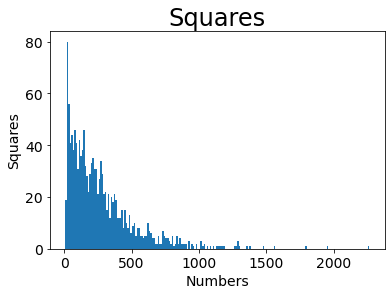

In [41]:
import matplotlib.pyplot as plt
import numpy as np
_ = plt.hist(train_df['text_len'], bins=200)
plt.xlabel('Text char count')
plt.title("Histogram of char count")
x_values=list(range(0,1000,50))
#x轴的数字是0到10这11个整数
y_values=[x/10 for x in x_values]

#用plot函数绘制折线图，线条颜色设置为绿色
plt.title('Squares',fontsize=24)
#设置图表标题和标题字号
plt.tick_params(axis='both',which='major',labelsize=14)
#设置刻度的字号
plt.xlabel('Numbers',fontsize=14)
#设置x轴标签及其字号
plt.ylabel('Squares',fontsize=14)
#设置y轴标签及其字号

In [32]:
from collections import Counter
all_lines = ' '.join(list(train_df['text']))
word_count = Counter(all_lines.split(' '))
word_count = sorted(word_count.items(), key=lambda d:d[1], reverse = True)

print(len(word_count))

print(word_count[0])
print(word_count[1])
print(word_count[2])

print(word_count[-1])

41130
('家', 5541)
('说', 3236)
('价', 1969)
('刘宝瑞', 1)


In [53]:
# Count Vectors + RidgeClassifier
print(train_df['label'])
train_df['label'] = train_df['label'].astype('int')
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import f1_score

all_data_size = 1200
train_data_size = 1000
test_data_size = all_data_size - train_data_size


vectorizer = CountVectorizer(max_features=3000)
train_test = vectorizer.fit_transform(train_df['text'])

print(train_test[0].shape )
clf = RidgeClassifier()
clf.fit(train_test[:train_data_size], train_df['label'].values[:train_data_size])
val_pred = clf.predict(train_test[train_data_size:])

print(f1_score(train_df['label'].values[train_data_size:], val_pred, average='macro'))
# 0.28

# svm
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=30, gamma=0.5, decision_function_shape='ovo')
clf.fit(train_test[:train_data_size], train_df['label'].values[:train_data_size])
val_pred = clf.predict(train_test[train_data_size:])

print(f1_score(train_df['label'].values[train_data_size:], val_pred, average='macro'))


from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors = 13 , weights='distance')
clf.fit(train_test[:train_data_size], train_df['label'].values[:train_data_size])
val_pred = clf.predict(train_test[train_data_size:])

print(f1_score(train_df['label'].values[train_data_size:], val_pred, average='macro'))

0          0
1          0
10         0
100        0
1000       0
          ..
799071    13
799072    13
799073    13
799074    13
799075    13
Name: label, Length: 1386, dtype: int32
(1, 3000)
0.012471655328798185
0.019585253456221197
0.0


In [54]:
# TF-IDF +  RidgeClassifier

import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score


tfidf = TfidfVectorizer(ngram_range=(1,4), max_features=3000)

train_test = tfidf.fit_transform(train_df['text'])

clf = RidgeClassifier()
clf.fit(train_test[:train_data_size], train_df['label'].values[:train_data_size])

val_pred = clf.predict(train_test[train_data_size:])

print(f1_score(train_df['label'].values[train_data_size:], val_pred, average='macro'))

0.017857142857142856


In [58]:
# 引入外部语义来训练word2vec
# 从之前的项目中找
import pymysql

db = pymysql.connect(host="47.97.215.99", user="root", passwd="3.1415Pai", database="news", charset='utf8')
# 使用cursor()方法获取操作游标
cursor = db.cursor()

# 读取数据库 create_table_news 中的title
sql = "SELECT  title " \
      "FROM create_table_news " \
      "ORDER BY news_id DESC " \
      "LIMIT 100 "
cursor.execute(sql)
title_list = cursor.fetchall()

# doc_data 记录 文章数据
doc_data = set()

for doc in title_list:
    if doc == None or len(doc) < 1:
        continue
    doc = str(doc[0])
    doc = doc.replace(" ","").replace("\n","")
    if doc == None or len(doc) < 1:
        continue
    doc_data.add(doc)
    
# 读取数据库 create_table_news 中的title
sql1 = "SELECT doc_content " \
      "FROM create_table_news " \
      "ORDER BY news_id DESC " \
      "LIMIT 100 "
cursor.execute(sql1)
doc_content_list = cursor.fetchall()
for doc in doc_content_list:
    if doc == None or len(doc) < 1:
        continue
    doc = str(doc[0])
    doc = doc.replace(" ","").replace("\n","")
    if doc == None or len(doc) < 1:
        continue
    doc_data.add(doc)


# 为word2vec 准备 切割后的语料common_text


In [ ]:


doc_data = train_df['text']
common_text = []
for i in range(0, doc_data.size):
    doc = str(doc_data[i]).split(" ")
    common_text.append(doc)

# 训练word2vec



In [ ]:


useless = set()
for i in range(0, 4):
    if int(word_count[i][1]) > len(word_count)*2:
        useless.add(word_count[i][0])
doc_data = train_df['text']
common_text = []
for i in range(0, doc_data.size):
    doc = str(doc_data[i]).split(" ")
    common_text.append(doc)

# 词向量的维度，样本够的话300-500。
# min_count 最小次数计数，出现次数低于这个数的就不要了
# workers  线程数
# window 窗口大小
# sample 负例采样设置aa


vector_size = 500
model = Word2Vec(sentences=common_text, vector_size=vector_size, window=5, min_count=4,
                  workers=12, sample=1e-5)
# model.save("word2vec.model")
vector = model.wv['中国']

# 词向量 合成 文本向量
doc_v_list = np.array([])

for split_doc in common_text:
    used_word = float(0.0)
    vector = vector * 0
    for word in split_doc:
        
        if word in useless: continue

        used_word += 1.0
        try:
            vector += model.wv[word]
        except Exception as e:
            # print(e.__traceback__.tb_frame.f_globals["__file__"])  # 发生异常所在的文件
            # print(e.__traceback__.tb_lineno)  # 发生异常所在的行数
            used_word -= 1.0

    vector /= used_word /200
    doc_v_list = np.append(doc_v_list, vector)

train_test = doc_v_list.reshape(len(common_text), vector_size)

# 使用word2vec 
clf = RidgeClassifier()
clf.fit(train_test[:train_data_size], train_df['label'].values[:train_data_size])

val_pred = clf.predict(train_test[train_data_size:])
print(f1_score(train_df['label'].values[train_data_size:], val_pred, average='macro'))